In [1]:
import numpy as np
import sys
import time
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
# from ipykernel.pylab.backend_inline import flush_figures
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
from ipywidgets import interact
# import ipywidgets as widgets

In [89]:
def sigmoid(X):
    return 1. / (1. + np.exp(-X))

def sigmoid_grad(X):
    return sigmoid(X) * ( 1 - sigmoid(X) )

def relu(X):
    return (X + np.abs(X)) / 2.

def relu_grad(X):
#     return relu(X) - relu(X-1)
    return sigmoid(X)

class NeuralNetworkWithPCA(object):
    def __init__(self, num_input=2, num_hidden=2, num_output=1, learning_rate=0.1, num_epochs=10, activation='relu'):
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        
        self.weights_0_1 = np.zeros((num_input, num_hidden))
        # self.weights_1_2 = np.zeros((num_hidden, num_output))
        self.weights_1_2 = np.random.randn(num_hidden, num_output)
        
        self.activation, self.activation_grad = self._activation_function(activation)
        self.training_accuracy = np.zeros((self.num_epochs))
        self.mse = np.zeros((self.num_epochs))
        self.weights_0_1_history = np.zeros((self.num_epochs, num_input, num_hidden))
        self.weights_1_2_history = np.zeros((self.num_epochs, num_hidden, num_output))
    
    def _activation_function(self, name):
        funcs = {
            'relu': (relu, relu_grad),
            'sigmoid': (sigmoid, sigmoid_grad),
        }
        return funcs[name]
    
    def _compute_gradient(self, x, y):
        pass
    
    def _forward(self, X):
        self.input = X
        self.hidden = self.activation(np.dot(self.input, self.weights_0_1))
        self.output = self.activation(np.dot(self.hidden, self.weights_1_2))
        return self.output
    
    def fit(self, X, y):
        n = X.shape[0]
        start = time.time()
        num_progress_bars = 20
        
        for i in range(self.num_epochs):
            self._forward(X)
            error = y - self.output
            self.grad_output = error * self.activation_grad(self.output)
            self.grad_hidden = np.dot(self.grad_output, self.weights_1_2.T) * self.activation_grad(self.hidden)
            self.dw_1_2 = np.dot(self.hidden.T, self.grad_output)
            self.dw_0_1 = np.dot(self.input.T, self.grad_hidden)
            self.weights_1_2 += self.learning_rate * self.dw_1_2 / n
            self.weights_0_1 += self.learning_rate * self.dw_0_1 / n
            
            self.weights_0_1_history[i] = self.weights_0_1
            self.weights_1_2_history[i] = self.weights_1_2

            finish = time.time()
            elapsed_time = float(time.time() - start)

            # l2_error = np.linalg.norm(error, ord=2, axis=1)
            correct = len([e for e in error if abs(e) < 0.5])
            training_accuracy = float(correct) / n
            self.training_accuracy[i] = training_accuracy
            
            mse = np.sum(error**2) / n
            self.mse[i] = mse
            
            progress = round(float(i)/self.num_epochs * num_progress_bars)

            sys.stdout.write("\r" + " "*80)
            sys.stdout.write(("\rTraining Accuracy: %0.3g%% Time elapsed: %0.2gs |" + "="*(progress) + " "*(num_progress_bars-progress) + "|") % (training_accuracy * 100, elapsed_time))
    
    def predict(self, X):
        return self.predict_proba(X)
    
    def predict_proba(self, X):
        return self._forward(X)
    
    def score(self, X, y):
        n = X.shape[0]
        self._forward(X)
        error = y - self.output
        correct = len([e for e in error if abs(e) < 0.5])
        training_accuracy = float(correct) / n
        return training_accuracy
    
    def _mse(self, X, y, epoch=None):
        n = X.shape[0]
        output = self._forward_history(X, epoch=epoch)
        mse = (y - output)**2
        return np.sum(error) / n
    
    def _layer_0_transform(self, X, epoch=None):
        epoch = self.num_epochs - 1 if epoch is None else epoch
        return self.activation(np.dot(X, self.weights_0_1_history[epoch]))
    
    def _forward_history(self, X, epoch=None):
        epoch = self.num_epochs - 1 if epoch is None else epoch
        hidden = self.activation(np.dot(X, self.weights_0_1_history[epoch]))
        output = self.activation(np.dot(hidden, self.weights_1_2_history[epoch]))
        return output

In [184]:
nn = NeuralNetworkWithPCA(num_input=10, num_hidden=1000, num_epochs=10)
n = 1000
X = np.random.randn(n, 10)
y = np.random.randint(2, size=(n, 1))
nn.fit(X, y)

Training Accuracy: 55.1% Time elapsed: 0.81s |==================  |             

In [187]:
nn.predict(np.zeros((1, 10)) + 1)

array([[ 0.55927684]])

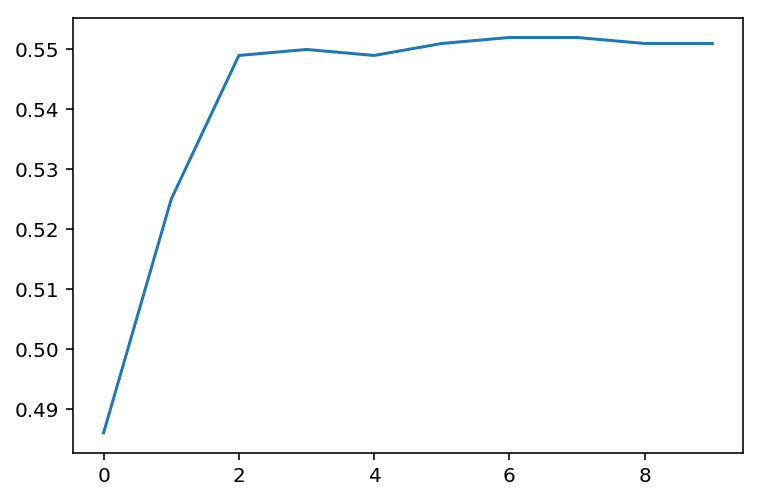

In [188]:
plt.plot(nn.training_accuracy)

Training Accuracy: 48.6% Time elapsed: 0.0074s |======              |

Training Accuracy: 48.6% Time elapsed: 0.006s |====                |

Training Accuracy: 51.4% Time elapsed: 0.01s |======              |

Training Accuracy: 51.4% Time elapsed: 0.019s |======              |

Training Accuracy: 51.4% Time elapsed: 0.061s |==================  |            

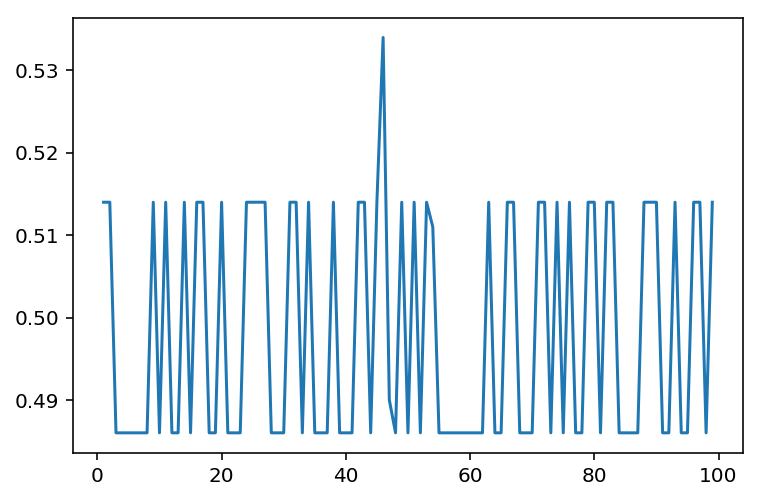

In [191]:
nhs = range(1,100)
nns = [NeuralNetworkWithPCA(num_input=10, num_hidden=nh, num_epochs=10) for nh in nhs]
for nn in nns:
    nn.fit(X, y)
ta = [nn.training_accuracy[-1] for nn in nns]
plt.plot(nhs, ta)

In [222]:
data = load_digits()
X = data.data
y = data.target
y = np.array([(lambda x: x if x == 4 else 0)(i) for i in data.target])
# print(X[:10])
print(X.shape)
print(y[:10])
# print(y[:100])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42)
# print(X_train[:100], y_train[:100])

(1797, 64)
[0 0 0 0 4 0 0 0 0 0]


/Users/AnnaLeonard/miniconda3/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1797, 64)
Training Accuracy: 61.2% Time elapsed: 0.022s |========            |

/Users/AnnaLeonard/miniconda3/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training Accuracy: 90.3% Time elapsed: 0.048s |================    |

Training Accuracy: 90.6% Time elapsed: 0.059s |===============     |

Training Accuracy: 83.4% Time elapsed: 0.047s |==============      |

Training Accuracy: 66.9% Time elapsed: 0.033s |=========           |

Training Accuracy: 63% Time elapsed: 0.22s |=================== |               

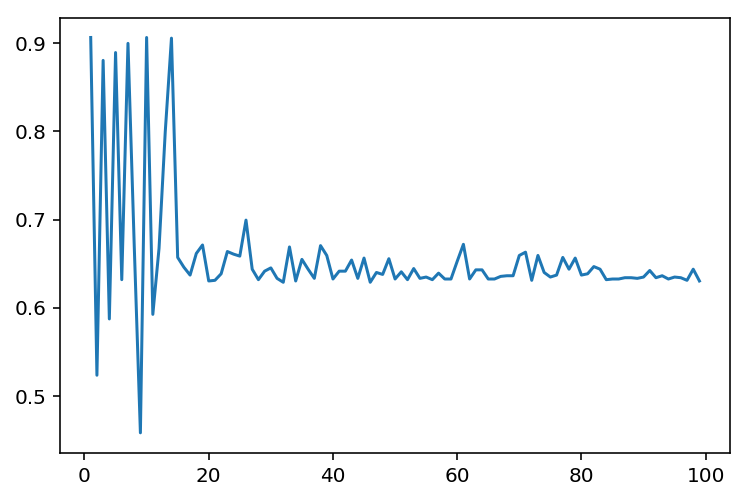

In [215]:
nhs = range(1,100)
nns = [NeuralNetworkWithPCA(num_input=64, num_hidden=nh, num_epochs=20) for nh in nhs]
for nn in nns:
    nn.fit(X_train, y_train)
ta = [nn.training_accuracy[-1] for nn in nns]
plt.plot(nhs, ta)

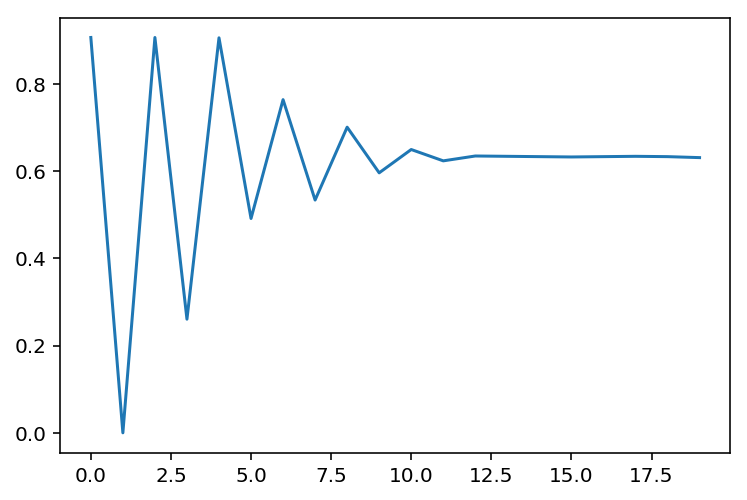

In [216]:
plt.plot(nns[20].training_accuracy)

In [85]:
clf = MLPClassifier(hidden_layer_sizes=(4), max_iter=1000, activation='relu')
clf.fit(X_train, y_train)

/Users/AnnaLeonard/miniconda3/envs/py3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=4, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [86]:
clf.score(X_test, y_test)

0.94799999999999995

In [90]:
nn = NeuralNetworkWithPCA(num_input=2, num_hidden=3, num_epochs=1000, learning_rate=1)
nn.fit(X_train, y_train[:, None])

Training Accuracy: 76.9% Time elapsed: 0.43s |====                |

Training Accuracy: 95.5% Time elapsed: 2.8s |====================|              

In [91]:
nn.score(X_test, y_test[:, None])

0.936

Text(0,0.5,'Training accuracy (%)')

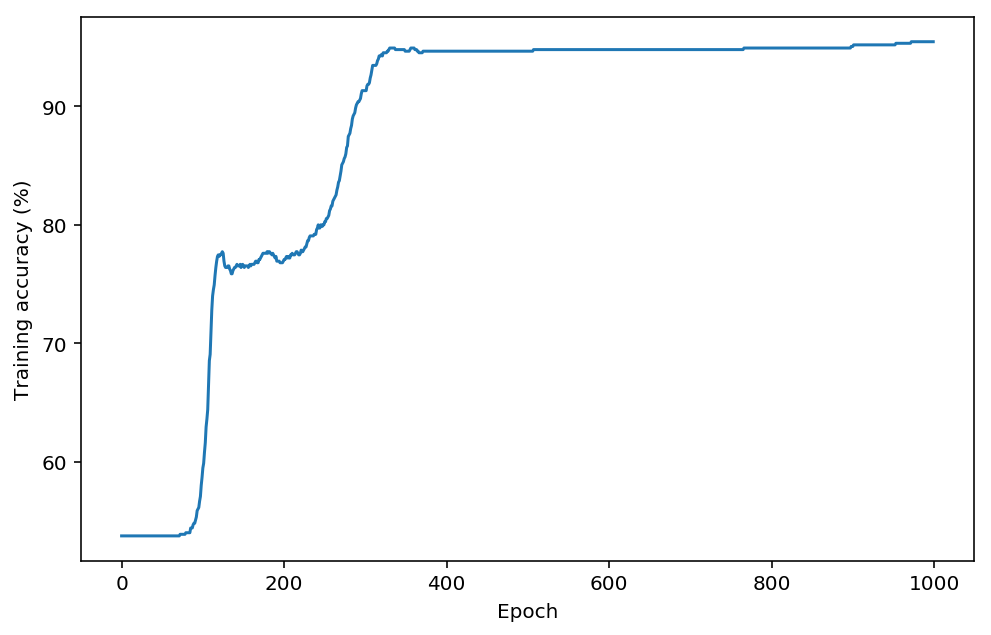

In [100]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
ax.plot(nn.training_accuracy*100)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy (%)")

In [92]:
@interact(epoch=(0,nn.num_epochs-1))
def plot_transform(epoch):
    Xt = nn._layer_0_transform(X_test, epoch=epoch)
    c0t = select_class(Xt, y_test, class_val=0)
    c1t = select_class(Xt, y_test, class_val=1)

    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(c0t[:, 0], c0t[:, 1], c0t[:, 2])
    ax.scatter(c1t[:, 0], c1t[:, 1], c1t[:, 2])
    
    ax2 = fig.add_subplot(122)
    ax2.plot(nn.training_accuracy)
    ax2.scatter(epoch, nn.training_accuracy[epoch], color='red', s=100)
    
    plt.show()
    

interactive(children=(IntSlider(value=499, description='epoch', max=999), Output()), _dom_classes=('widget-interact',))

In [22]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
output_notebook()
from scatter3d import Scatter3d

epoch = 100

epochs = np.linspace(0, nn.num_epochs-1, nn.num_epochs)

Xt = nn._layer_0_transform(X_test, epoch=epoch)
c0t = select_class(Xt, y_test, class_val=0)
c1t = select_class(Xt, y_test, class_val=1)

source_0 = ColumnDataSource(data={
    'x': c0t[:, 0],
    'y': c0t[:, 1],
    'z': c0t[:, 2],
})
source_1 = ColumnDataSource(data={
    'x': c1t[:, 0],
    'y': c1t[:, 1],
    'z': c1t[:, 2],
})
p0 = figure(title="output perceptron input space")
p0.add_glyph(Scatter3d(data_source=source_0))
# r = p0.scatter(c0t[:, 0], c0t[:, 1], c0t[:, 2])

p1 = figure(title="training error")
r = p1.line(epochs, nn.training_accuracy)
s = p1.scatter([0], [nn.training_accuracy[0]])

# hplot(p0, p1, notebook_handle=True)
show(p0, notebook_handle=True)

@interact(epoch=(0, nn.num_epochs-1))
def update(epoch):
    s.data_source.data['x'] = [epoch]
    s.data_source.data['y'] = [nn.training_accuracy[epoch]]
    push_notebook()

# @interact(epoch=(0,nn.num_epochs-1))
# def plot_transform(epoch):
#     Xt = nn._layer_0_transform(X_test, epoch=epoch)
#     c0t = select_class(Xt, y_test, class_val=0)
#     c1t = select_class(Xt, y_test, class_val=1)

#     fig = plt.figure(figsize=(15,7))
#     ax = fig.add_subplot(121, projection='3d')
#     ax.scatter(c0t[:, 0], c0t[:, 1], c0t[:, 2])
#     ax.scatter(c1t[:, 0], c1t[:, 1], c1t[:, 2])
    
#     ax2 = fig.add_subplot(122)
#     ax2.plot(nn.training_accuracy)
#     ax2.scatter(epoch, nn.training_accuracy[epoch])
    
#     plt.show()

Loading BokehJS ...

ValueError: 'glyph' argument to add_glyph() must be Glyph subclass

In [ ]:
lrs = np.linspace(0,1,)
nns = [NeuralNetworkWithPCA(num_input=64, num_hidden=nh, num_epochs=20) for nh in nhs]
for nn in nns:
    nn.fit(X_train, y_train)
ta = [nn.training_accuracy[-1] for nn in nns]
plt.plot(nhs, ta)

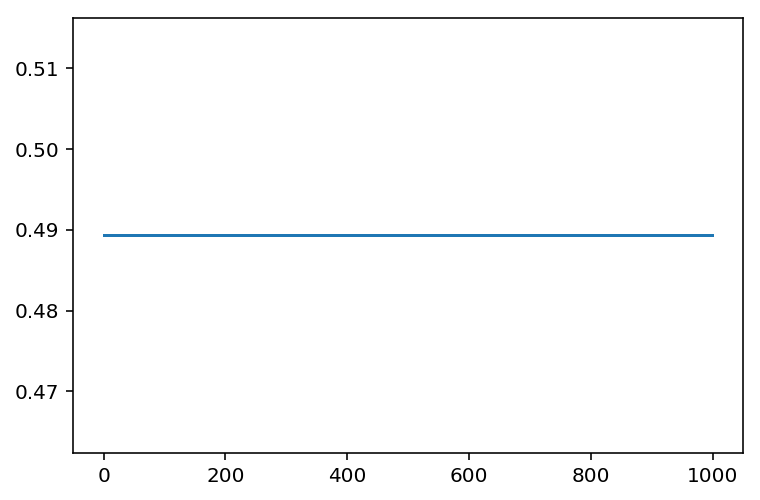

In [100]:
plt.plot(nn.training_accuracy)

In [72]:
nn.weights_0_1

array([[ 0.00720988,  0.01179663, -0.22366983,  0.0958279 ,  0.14306656,
        -0.02044437, -0.15137847,  0.01650205, -0.01552051,  0.01758768],
       [ 0.35429413,  0.0312504 , -0.13617955, -0.03070313, -0.06920916,
        -0.01366924, -0.09789056,  0.01420209, -0.01054997,  0.02008352]])

In [73]:
nn.weights_1_2

array([[ 1.43906523],
       [-1.16408351],
       [ 1.17212169],
       [ 1.82182569],
       [ 1.93092617],
       [ 0.24648178],
       [ 0.91479108],
       [-0.28716792],
       [ 0.19617001],
       [-0.43270241]])

In [3]:
n = 1000
X = np.random.randn(n, 2)
# f = np.array([(i, sum([sum([1 if np.linalg.norm(x) >= i else 0 for x in X]) for _ in range(100)]) / 100) for i in np.linspace(0, 1.5, 50)])
y = np.array([1 if np.linalg.norm(x) >= 1.17 else 0 for x in X])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42)

/Users/AnnaLeonard/miniconda3/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


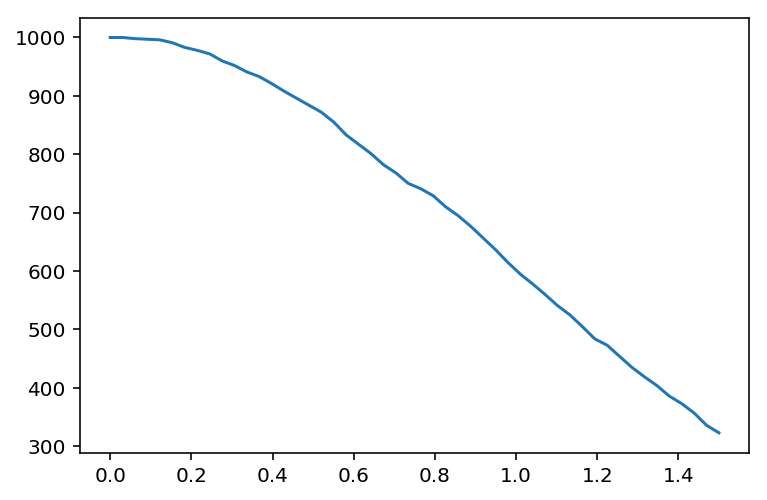

In [292]:
plt.plot(f[:, 0], f[:, 1])

In [293]:
[x for x in f if abs(x[1]-500) < 50]

[array([   1.10204082,  541.        ]),
 array([   1.13265306,  525.        ]),
 array([   1.16326531,  505.        ]),
 array([   1.19387755,  484.        ]),
 array([   1.2244898,  473.       ]),
 array([   1.25510204,  454.        ])]

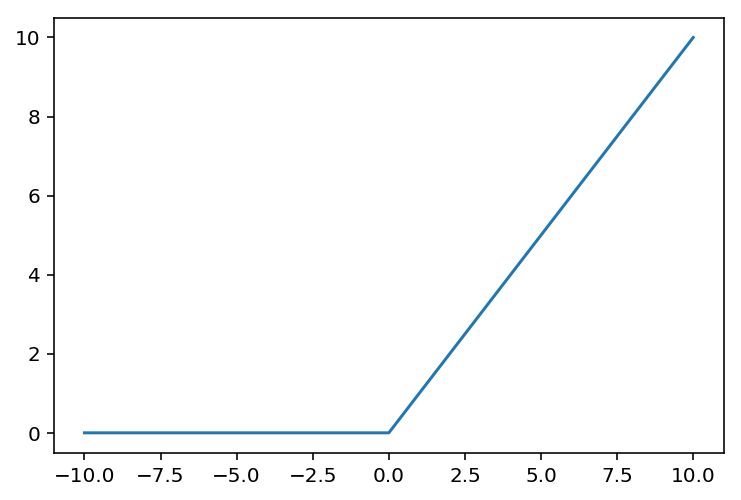

In [42]:
plt.plot(np.linspace(-10,10,21), relu(np.linspace(-10,10,21)))

In [38]:
z = np.linspace(-10,10,21)
(z + np.abs(z)) / 2.

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

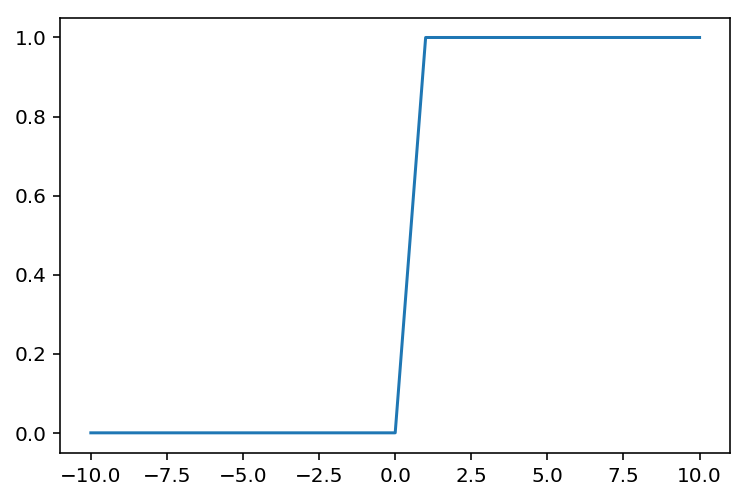

In [108]:
def relu_grad(X):
#     return sigmoid(X)
    return relu(X) - relu(X-1)
plt.plot(np.linspace(-10,10,21), relu_grad(np.linspace(-10,10,21)))

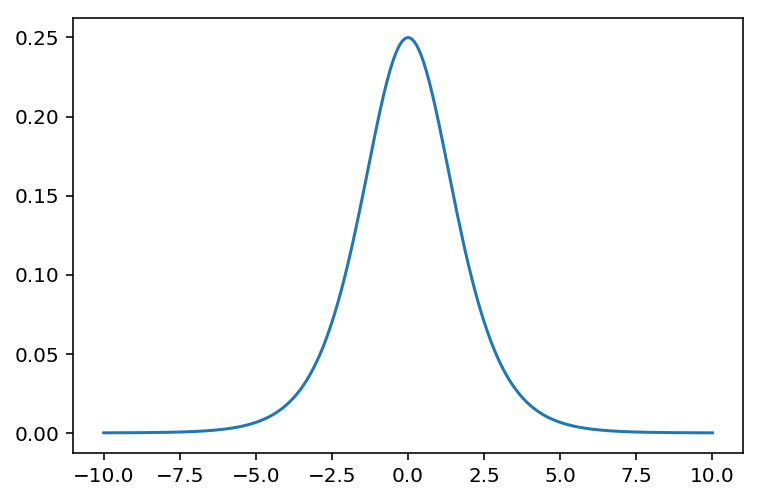

In [91]:
z = np.linspace(-10,10,201)
plt.plot(z, sigmoid_grad(z))

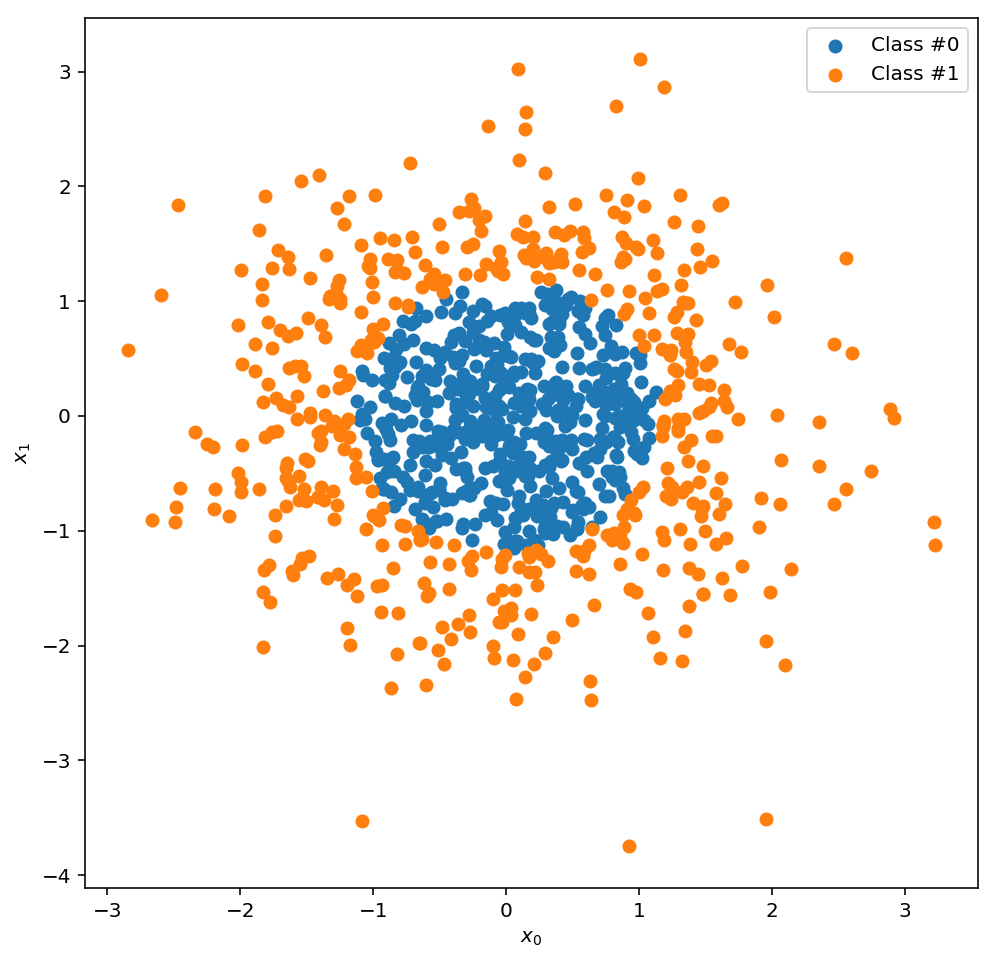

In [105]:
c0 = select_class(X, y, class_val=0)
c1 = select_class(X, y, class_val=1)
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(c0[:, 0], c0[:, 1], label='Class #0')
ax.scatter(c1[:, 0], c1[:, 1], label='Class #1')
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.legend()

In [5]:
def select_class(X, y, class_val=1):
    return np.array([X[i] for i in range(len(y)) if y[i] == class_val])

In [23]:
import json

In [30]:
with open('data_0.json', 'w') as f:
    json.dump(select_class(X, y, class_val=0).tolist(), f)
with open('data_1.json', 'w') as f:
    json.dump(select_class(X, y, class_val=1).tolist(), f)

In [32]:
with open('weights.json', 'w') as f:
    json.dump(nn.weights_0_1_history.tolist(), f)

In [72]:
w = nn.weights_0_1_history.copy()
w = np.transpose(w, axes=(0,2,1))
w[669]

array([[-0.41578208,  0.1635736 ],
       [ 0.03107706, -0.4579488 ],
       [ 0.13790373,  0.10893397]])

In [62]:
with open('weights.json', 'w') as f:
    json.dump(w.tolist(), f)

In [65]:
with open('weights_T.json', 'w') as f:
    json.dump(nn.weights_0_1_history.tolist(), f)

In [64]:
with open('accuracy.json', 'w') as f:
    json.dump(nn.training_accuracy.tolist(), f)

In [63]:
nn.weights_0_1_history

array([[[ 0.00464536,  0.00688084, -0.00344324],
        [ 0.0080324 ,  0.01189782, -0.00595379]],

       [[ 0.0088948 ,  0.01303038, -0.00687707],
        [ 0.01535939,  0.02249297, -0.01188479]],

       [[ 0.01275891,  0.0184864 , -0.01030217],
        [ 0.02200116,  0.03185586, -0.01779366]],

       ..., 
       [[-0.51947445, -0.00836382,  0.15574907],
        [ 0.25531123, -0.60292856,  0.10419301]],

       [[-0.51986658, -0.00850692,  0.1558005 ],
        [ 0.25564748, -0.60344834,  0.10417938]],

       [[-0.52025921, -0.00865012,  0.15585192],
        [ 0.25598399, -0.60396859,  0.10416578]]])

In [80]:
w[720]

array([[-0.42923693,  0.17529718],
       [ 0.02629258, -0.47715537],
       [ 0.14069837,  0.10833411]])

In [81]:
c0[100]

array([ 0.77292725, -0.69765798])

In [85]:
relu(np.dot(c0[100], w[720].T))

array([ 0.        ,  0.35321351,  0.03316945])

In [78]:
nn._layer_0_transform(c0[100], epoch=720)

array([ 0.        ,  0.35321351,  0.03316945])

In [79]:
nn._layer_0_transform(c1[100], epoch=720)

array([ 0.48384038,  0.30127167,  0.        ])

In [86]:
def mse(nn, X, y, epoch=0):
    n = X.shape[0]
    output = nn._layer_0_transform(X, epoch=epoch)
    mse = (y - output)**2
    return np.sum(error) / n

In [87]:
mse(nn, X_train, y_train)

ValueError: operands could not be broadcast together with shapes (750,) (750,3) 

Text(0,0.5,'Mean Squared Error')

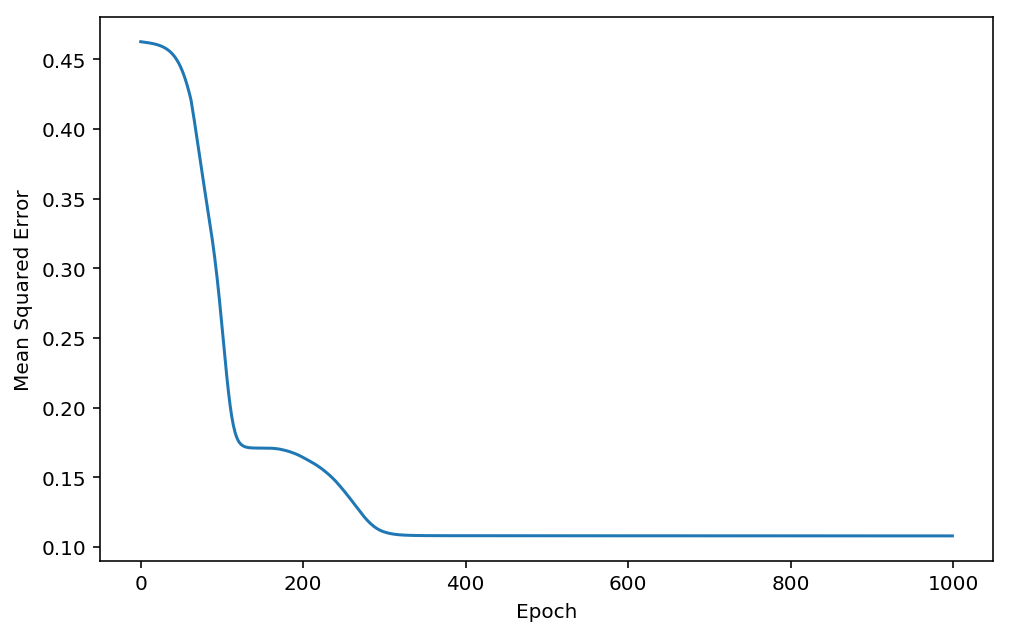

In [107]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes()
ax.plot(range(0,1000), nn.mse)
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Squared Error')